In [1]:
from keras.datasets import mnist
from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization
from keras.models import Model
import keras.backend as K
from keras.utils import to_categorical
import numpy as np
from keras.callbacks import EarlyStopping
from keras.engine.topology import Layer

Using TensorFlow backend.


In [2]:
inputs=Input((28,28,1))
x=Conv2D(32,(3,3))(inputs)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(32,(3,3))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(64,(5,5))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(64,(5,5))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(128,(7,7))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Conv2D(128,(7,7))(x)
x=BatchNormalization()(x)
x=PReLU()(x)
x=Flatten()(x)
x=Dense(2)(x)
out1=PReLU(name="out1")(x)
out2=Dense(10,activation="softmax")(out1)

model=Model(inputs,out2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 26, 26, 32)        21632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 24, 24, 32)        18432     
__________

In [3]:
-
model_center_loss.summary()        

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 26, 26, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 26, 26, 32)   21632       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
path="mnist.npz"
f = np.load(path)
x_train, y_train = f['x_train'][:30000], f['y_train'][:30000]
x_test, y_test = f['x_test'], f['y_test']
f.close()

x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
x_train/=255.
x_test/=255.
x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)

y_train_one_hot=to_categorical(y_train)
y_test_one_hot=to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(y_train_one_hot.shape)

(30000, 28, 28, 1)
(30000,)
(30000, 10)


In [5]:
dummy_matrix1=np.zeros((x_train.shape[0],1))
dummy_matrix2=np.zeros((x_test.shape[0],1))

model_center_loss.fit(x=[x_train,y_train_one_hot],y=[y_train_one_hot,dummy_matrix1],
                     batch_size=512,epochs=100,verbose=1,validation_data=([x_test,y_test_one_hot],[y_test_one_hot,dummy_matrix2]),
                     callbacks=[EarlyStopping(monitor="val_loss",patience=20)])

Train on 30000 samples, validate on 10000 samples
Epoch 1/100
30000/30000 [==============================] - 7s 235us/step - loss: 2.3103 - dense_2_loss: 2.2998 - center_loss_layer_1_loss: 0.0210 - dense_2_acc: 0.1297 - center_loss_layer_1_acc: 0.9905 - val_loss: 2.2985 - val_dense_2_loss: 2.2945 - val_center_loss_layer_1_loss: 0.0079 - val_dense_2_acc: 0.1481 - val_center_loss_layer_1_acc: 0.9973
Epoch 2/100
30000/30000 [==============================] - 5s 160us/step - loss: 2.2850 - dense_2_loss: 2.2643 - center_loss_layer_1_loss: 0.0413 - dense_2_acc: 0.1505 - center_loss_layer_1_acc: 0.9771 - val_loss: 2.2612 - val_dense_2_loss: 2.2033 - val_center_loss_layer_1_loss: 0.1158 - val_dense_2_acc: 0.1647 - val_center_loss_layer_1_acc: 0.9331
Epoch 3/100
30000/30000 [==============================] - 5s 159us/step - loss: 2.1977 - dense_2_loss: 2.1397 - center_loss_layer_1_loss: 0.1160 - dense_2_acc: 0.1865 - center_loss_layer_1_acc: 0.9464 - val_loss: 2.1450 - val_dense_2_loss: 2.0420 

In [6]:
func=K.function([model.input],[model.get_layer('out1').output])
test_features= func([x_test])[0]
print(test_features.shape)

test_centers=np.dot(np.transpose(y_test_one_hot),test_features)
test_centers_count=np.sum(np.transpose(y_test_one_hot),axis=1,keepdims=True)
test_centers/=test_centers_count
print(test_centers.shape)

(10000, 2)
(10, 2)


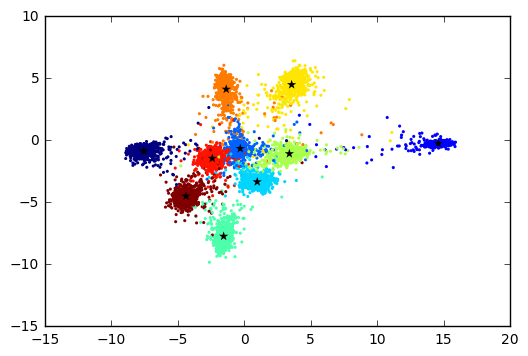

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(test_features[:,0],test_features[:,1],c=y_test,edgecolor="none",s=5)
plt.scatter(test_centers[:,0],test_centers[:,1],c="black",marker="*",edgecolor="none",s=50)
plt.show()